# Service types provision assessment

In [1]:
from blocksnet.models import City
city_model = City.from_pickle('new_model.pickle')

In [2]:
from blocksnet.method import Provision
prov = Provision(city_model=city_model)

In [4]:
prov.calculate('school')

TypeError: 'builtin_function_or_method' object is not iterable

In [119]:
import pandas as pd
from pulp import PULP_CBC_CMD, LpMinimize, LpProblem, LpVariable, lpSum, LpInteger
from itertools import product

service_type = city_model['school']

gdf = prov._get_blocks_gdf(service_type)

gdf['capacity_left'] = gdf['capacity']
gdf['demand_left'] = gdf['demand']
gdf['demand_within'] = 0
gdf['demand_without'] = 0

while sum(gdf['demand_left'])>0 and sum(gdf['capacity_left'])>0:
  
  demand_gdf = gdf.loc[gdf['demand_left']>0]
  capacity_gdf = gdf.loc[gdf['capacity_left']>0]
  
  print(len(demand_gdf), len(capacity_gdf))

  matrix = pd.DataFrame(0, index=demand_gdf.index, columns=capacity_gdf.index)
  adj_mx = city_model.adjacency_matrix.loc[demand_gdf.index, capacity_gdf.index]

  def foobar(row):
    i_min = row.idxmin()
    new_row = row.copy()
    new_row[i_min] = 1
    return new_row

  #нашли кто и куда кидает людей и с какой пропорцией
  matrix = adj_mx.apply(foobar,axis=1)

  demand = demand_gdf.copy()
  demand_index = demand.index
  min_demand = demand['demand_left'].min()

  capacity_index = matrix.apply(lambda x : x>0).any().index
  capacity = capacity_gdf.loc[capacity_index]
  min_capacity = capacity['capacity_left'].min()


  # print(min_demand, min_capacity)
  min_value = min(min_demand, min_capacity)
  # print(min_value)

  gdf.loc[demand_index, 'demand_left'] -= min_value
  gdf.loc[demand_index, 'demand_within'] += min_value
  gdf.loc[capacity_index, 'capacity_left'] -= min_value


2087 492
1997 492
1918 492
1856 492
1805 492
1780 492
1749 492
1729 492
1703 492
1676 492
1658 492
1636 492
1618 492
1599 492
1588 492
1580 492
1570 492
1559 492
1545 492
1532 492
1523 492
1515 492
1504 492
1498 492
1488 492
1483 492
1474 492
1466 492
1462 492
1447 492
1438 492
1425 492
1420 492
1409 492
1394 492
1385 492
1376 492
1365 492
1348 492
1343 492
1338 492
1324 492
1314 492
1306 492
1300 492
1291 492
1284 492
1275 492
1265 492
1254 492
1249 492
1238 492
1231 492
1222 492
1215 491
1211 491
1204 491
1200 491
1197 491
1191 490
1182 490
1175 490
1164 490
1154 490
1148 490
1143 490
1137 488
1132 488
1124 488
1117 488
1110 488
1099 486
1094 485
1090 484
1080 484
1069 482
1059 482
1055 482
1048 482
1043 481
1039 481
1034 481
1027 481
1020 481
1013 481
1008 481
998 481
993 481
987 481
985 481
981 480
980 480
979 480
972 480
966 480
964 480
958 479
955 479
949 479
946 479
937 479
935 479
931 479
927 479
923 478
920 478
917 478
913 477
907 477
898 476
895 476
889 476
886 476
884 475
88

<Axes: title={'center': 'Provision:  1.000'}>

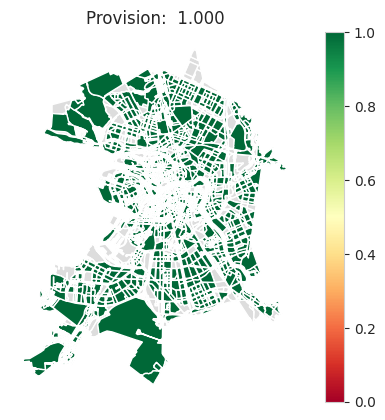

In [127]:
gdf['provision'] = gdf['demand_within'] / gdf['demand']
prov.plot(gdf)

In [ ]:
def var_to_names(name):
  name = name.replace("(", "").replace(")", "").replace(",", "").split("_")
  return name[1], name[2]

df = pd.DataFrame([var.to_dict() for var in vars])
df['from'] = df['name'].apply(lambda x : var_to_names(x)[0]).apply(int)
df['to'] = df['name'].apply(lambda x : var_to_names(x)[1]).apply(int)

In [66]:
df = df.loc[df['from'] != 3839]
df = df.loc[df['to'] != 3839]

In [69]:
from math import sqrt

df['is_accessible'] = df['dj'].apply(sqrt).apply(lambda x : x<=city_model['kindergarten'].accessibility)

In [77]:
gdf = prov._get_blocks_gdf(city_model['kindergarten'])

In [78]:
gdf

,geometry,capacity,demand,demand_left,demand_within,demand_without,capacity_left
id,,,,,,,
0,"POLYGON ((21256.898 6676646.063, 21256.898 667...",560,176,176,0,0,560
1,"POLYGON ((21579.273 6676542.669, 21569.628 667...",0,2,2,0,0,0
2,"POLYGON ((15519.724 6685090.109, 15537.179 668...",280,258,258,0,0,280
3,"POLYGON ((23226.132 6680490.489, 23203.720 668...",0,134,134,0,0,0
4,"POLYGON ((23190.502 6680401.003, 23193.601 668...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
3834,"POLYGON ((16971.005 6683010.295, 16928.042 668...",0,0,0,0,0,0
3835,"POLYGON ((17617.836 6662709.760, 17622.174 666...",0,0,0,0,0,0
3836,"POLYGON ((24097.913 6661657.331, 24122.154 666...",0,0,0,0,0,0


In [85]:
gdf['demand_within'] = df.loc[df.is_accessible].groupby('from').agg({'varValue':'sum'})['varValue'].apply(int)
gdf['demand_without'] = df.loc[~df.is_accessible].groupby('from').agg({'varValue':'sum'})['varValue'].apply(int)
gdf['capacity_left'] = gdf['capacity'] - df.loc[~df.is_accessible].groupby('from').agg({'varValue':'sum'})['varValue'].apply(int)

In [89]:
gdf['provision'] = gdf['demand_within'] / gdf['demand']

<Axes: title={'center': 'Provision:  0.937'}>

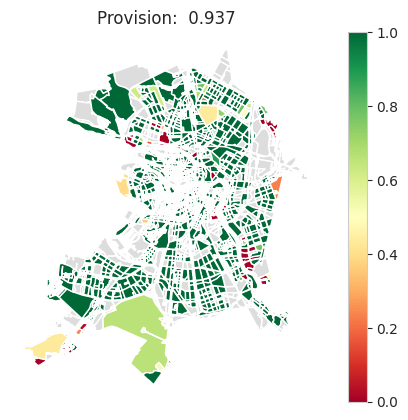

In [91]:
prov.plot(gdf)

In [5]:
import pandas as pd

update = {
  148: {
    'population': 10000,
  }
}

update_df = pd.DataFrame.from_dict(update, orient='index')

In [6]:
calc_after, weights_after = prov.calculate('kindergartens', update_df=update_df, method='gravity')
ax = prov.plot(calc_after)
weights_gdf = prov.weights_to_gdf(weights_after)
weights_gdf.plot(column='weight', ax=ax)

KeyError: "Can't find service type with such name: kindergartens"

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


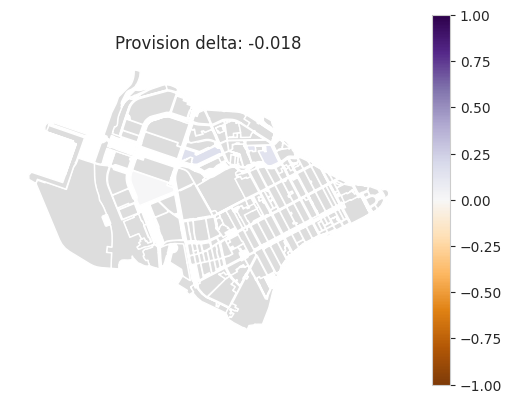

In [ ]:
prov.plot_delta(calc_before, calc_after)

In [ ]:
Provision.stat_provision(calc_before)

{'mean': 0.5986625218033782, 'median': 1.0, 'min': 0.0, 'max': 1.0}

In [ ]:
Provision.stat_provision(calc_after)

{'mean': 0.6010412227397885, 'median': 1.0, 'min': 0.0, 'max': 1.0}

In [ ]:
demand = calc_after.demand.sum()
capacity = calc_after.capacity.sum()
capacity/demand

0.7819813084112149

In [ ]:
scenario = {'schools': 0.5, 'kindergartens': 0.5}
gdf, total = prov.calculate_scenario(scenario)
print(total)

0.6709120101908853
